# run_car

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
dyn_plot = True
class DynamicUpdate():
    def on_launch(self):
        #Set up plot
        self.figure, self.ax = plt.subplots()
        self.lines, = self.ax.plot([],[])
        #Autoscale on unknown axis and known lims on the other
        self.ax.set_autoscaley_on(True)
        self.ax.set_autoscalex_on(True)
        #Other stuff
        self.ax.grid()

    def on_running(self, xdata, ydata):
        #Update data (with the new _and_ the old points)
        self.lines.set_xdata(xdata)
        self.lines.set_ydata(ydata)
        #Need both of these in order to rescale
        self.ax.relim()
        self.ax.autoscale_view()
        #We need to draw *and* flush
        self.figure.canvas.draw()
        self.figure.canvas.flush_events()

In [2]:
import datetime
import numpy as np
import random

In [3]:
from cars.world import SimpleCarWorld
from cars.agent import SimpleCarAgent
from cars.physics import SimplePhysics
from cars.track import generate_map

In [4]:
from tqdm import tqdm_notebook

In [5]:
from functools import reduce

In [6]:
import pandas as pd

In [7]:
import seaborn as sns

In [8]:
from run_car import create_map

# Параметры

In [9]:
map_seeds = [3, 13, 18, 23]
map_seed = map_seeds[0]

# Нарабатываем данные, учимся и оцениваемся

In [10]:
log_list = []

In [11]:
from run_car import mine_data, norm_y

In [12]:
from learning_algorithms.forest import RandomForestWrapper
from learning_algorithms.network import Network

In [13]:
kvparams = {
    "clear_history": False,
    "map_seed": map_seed,
    "epochs": 100,
    "mini_batch_size": 50,
    "eta": 0.5,
    "reward_shift": 3,
    "alpha": 0.7
}

act_trainer = {
    "low": 0.0,
    "high": 0.0,
    "random_default": 0.8,
    "random_bad": 0.8,
    "random_good": 0.8,
    "random_diff": 0.8
}

random.seed(42)
np.random.seed(42)
agent1 = SimpleCarAgent(name="Ivan", history_data=70000)
agent1.neural_net = Network([9, 18, 8, 1], output_function=lambda x: x, output_derivative=lambda x: 1)
# agent1.neural_net = RandomForestWrapper(n_estimators=50)

In [14]:
print("\n\n".join(log_list) + "\n----\n")
for _ in tqdm_notebook(range(1), desc="main"):
    mine_data(log_list, dyn_plot, agent1, act_trainer, steps=4000, **kvparams)


----



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 1.170269557, train_rmse_after = 0.187418321, 
mean_train_revard = -0.090, mean_test_reward  = -0.089,
steps = total: 4000, bad: 0.6052, good: 0.2655, diff: 0.1690, other: -0.0397,
collisions = 0.541250, circles = 0.238571



In [15]:
# Оценка парамтеров целевой функции
agent_rew_hist = norm_y(np.array(agent1.reward_history))
print(np.percentile(agent_rew_hist, np.linspace(0, 100, 11)))
print(np.linspace(agent_rew_hist.min(), agent_rew_hist.max(), 11))

[-0.68592934 -0.32630594 -0.28227493 -0.20440815 -0.10305747 -0.0143956
  0.01753487  0.04540315  0.06408689  0.07807082  0.09671349]
[-0.68592934 -0.60766505 -0.52940077 -0.45113649 -0.3728722  -0.29460792
 -0.21634364 -0.13807936 -0.05981507  0.01844921  0.09671349]


<IPython.core.display.Javascript object>


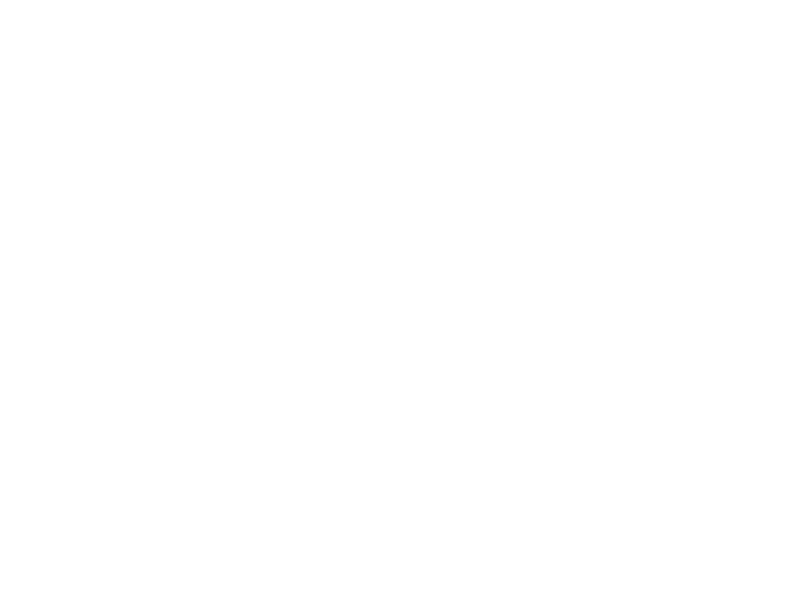

(array([   42.,    11.,    12.,    30.,   600.,   433.,   330.,   304.,
          652.,  1586.]),
 array([-0.68592934, -0.60766505, -0.52940077, -0.45113649, -0.3728722 ,
        -0.29460792, -0.21634364, -0.13807936, -0.05981507,  0.01844921,
         0.09671349]),
 <a list of 10 Patch objects>)

In [16]:
plt.hist(agent_rew_hist[:4000])

In [17]:
kvparams["eta"] = 0.1

act_trainer["low"] = -0.15
act_trainer["high"] = 0.2

act_trainer["random_default"] = 0.10
act_trainer["random_bad"] = 0.80
act_trainer["random_good"] = 0.15
act_trainer["random_diff"] = 0.10

In [18]:
print("\n\n".join(log_list) + "\n----\n")
res = 10
for _ in tqdm_notebook(range(10), desc="main"):
    for map_seed in map_seeds:
        kvparams["map_seed"] = map_seed
        res = mine_data(log_list, dyn_plot, agent1, act_trainer, steps=4000, **kvparams)
        if res > 2:
            break
        print("")
    if res > 2:
        break

map_seed = 3
train_rmse_before = 1.170269557, train_rmse_after = 0.187418321, 
mean_train_revard = -0.090, mean_test_reward  = -0.089,
steps = total: 4000, bad: 0.6052, good: 0.2655, diff: 0.1690, other: -0.0397,
collisions = 0.541250, circles = 0.238571
----



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.192819121, train_rmse_after = 0.172176635, 
mean_train_revard = -0.093, mean_test_reward  = -0.189,
steps = total: 4000, bad: 0.4763, good: 0.0075, diff: 0.0000, other: 0.5162,
collisions = 0.591750, circles = 0.338420



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.195043283, train_rmse_after = 0.154948786, 
mean_train_revard = -0.102, mean_test_reward  = -0.383,
steps = total: 4000, bad: 0.5062, good: 0.0000, diff: 0.0000, other: 0.4938,
collisions = 0.562750, circles = -0.000296



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 18
train_rmse_before = 0.229686982, train_rmse_after = 0.132156020, 
mean_train_revard = -0.118, mean_test_reward  = -0.058,
steps = total: 4000, bad: 0.4545, good: 0.0000, diff: 0.0000, other: 0.5455,
collisions = 0.536750, circles = 1.204668



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 23
train_rmse_before = 0.137335771, train_rmse_after = 0.123016308, 
mean_train_revard = -0.110, mean_test_reward  = -0.453,
steps = total: 4000, bad: 0.4815, good: 0.0022, diff: 0.0000, other: 0.5162,
collisions = 0.552250, circles = 0.012535



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 3
train_rmse_before = 0.148860670, train_rmse_after = 0.118140248, 
mean_train_revard = -0.122, mean_test_reward  = -0.024,
steps = total: 4000, bad: 0.4878, good: 0.0060, diff: 0.0000, other: 0.5062,
collisions = 0.609000, circles = 0.313385



A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

map_seed = 13
train_rmse_before = 0.115591281, train_rmse_after = 0.109070398, 
mean_train_revard = -0.116, mean_test_reward  = -0.290,
steps = total: 4000, bad: 0.4605, good: 0.0040, diff: 0.0000, other: 0.5355,
collisions = 0.612750, circles = 0.198274



A Jupyter Widget

A Jupyter Widget

KeyboardInterrupt: 

In [ ]:
import pickle

In [ ]:
agent1.to_file("nn_trained_on_50k.txt")

In [ ]:
agent1.neural_net = None

In [ ]:
pickle.dump(agent1, open("agent1.pickle", "wb"))

In [ ]:
agent1 = pickle.load(open("agent1.pickle", "rb"))

In [ ]:
agent1.neural_net = agent1.from_file("nn_trained_on_50k.txt").neural_net

# Смотрим вживую

In [ ]:
def visualize(agent, map_seed):
    w = create_map(seed=map_seed, agent=agent)
    eval_res = w.evaluate_agent(agent, steps=1200, visual=True)
    eval_circle = w.circles[agent]
    print(f"visualize on map = {map_seed}, eval_res = {eval_res:4f}, eval_circle = {eval_circle:4f}")

In [ ]:
for map_seed in map_seeds:
    visualize(agent1, map_seed)

# Отладка

In [ ]:
raise Exception("Здесь отладка")

In [21]:
agent_dbg = agent1

agent_dbg.clear_history()
#mine data
w = create_map(seed=map_seed, agent=agent_dbg)
w.run(steps=tqdm_notebook(range(10000), desc="train", leave=False), visual=False, save=False)

In [22]:
# prepare train data
X_train = np.concatenate([agent_dbg.sensor_data_history, agent_dbg.chosen_actions_history], axis=1)
y_train = np.array(agent_dbg.reward_history)
mean_train_revard = y_train.mean()
y_train = norm_y(y_train)
y_clean = y_train.copy()

mean_train_revard

-0.12005822168687524

In [23]:
reward_shift = kvparams["reward_shift"]
alpha = kvparams["alpha"]

In [24]:
y_train = np.pad(y_train, (0, 2 * reward_shift), mode="constant")
y_train = reduce(lambda a, b: a + b, [y_train[i:(-2 * reward_shift + i)] * (alpha ** i)
                                      for i in range(reward_shift)])

In [25]:
y_predict = agent_dbg.neural_net.feedforward(X_train.T)

In [26]:
pd_visual = pd.DataFrame(X_train,
                         columns=["velocity", "angle"] +
                         ["lid{}".format(i) for i in range(agent_dbg.rays)] +
                         ["steering", "acceleration"])
pd_visual["y_clean"] = y_clean
pd_visual["y_train"] = y_train
pd_visual["y_predict"] = y_predict.flatten()

## Смотрим на входные данные

In [ ]:
from functools import reduce

In [ ]:
pd_visual.loc[:4000]

In [ ]:
pd_visual.steering.hist(bins=3)

In [ ]:
pd_visual.acceleration.hist(bins=3)

In [ ]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(reward_shift+2)])].iloc[4000:]

In [ ]:
plt.ion()

In [ ]:
pd_visual["lid2"].hist(bins=np.arange(0,5,0.1))

In [ ]:
pd_visual[reduce(lambda a, b: a | b, [(pd_visual.y_clean < 0).shift(-i) for i in range(5, 10)])] \
    ["lid2"].hist(bins=np.arange(0,5,0.1))

## Смотрим как сеть реагирует на входные данные

In [ ]:
(pd_visual.y_clean[200:] < 0).argmax()

In [ ]:
pd_visual.loc[265:285]

In [ ]:
from cars.utils import Action

In [ ]:
sensor_info = pd_visual.loc[273].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
sensor_info = pd_visual.loc[275].values[:7]
rewards_to_controls_map = []
# дискретизируем множество значений, так как все возможные мы точно предсказать не сможем
for steering in np.linspace(-1, 1, 3):  # выбирать можно и другую частоту дискретизации, но
    for acceleration in np.linspace(-0.75, 0.75, 3):  # в наших тестах будет именно такая
        action = Action(steering, acceleration)
        agent_vector_representation = np.append(sensor_info, action)
        agent_vector_representation = agent_vector_representation.flatten()[:, np.newaxis]
        predicted_reward = float(agent_dbg.neural_net.feedforward(agent_vector_representation))
        rewards_to_controls_map.append((predicted_reward, action))

rewards_to_controls_map

In [ ]:
sorted(rewards_to_controls_map, key=lambda x: x[0])[-1]

In [ ]:
pd_visual[-8000:-6000].plot(y=["y_clean", "y_train", "y_predict"], figsize=(64, 4))

In [ ]:
rmse_before = ((pd_visual.y_train - pd_visual.y_predict)**2).mean() ** 0.5
rmse_before

# Смотрим как сеть учится

In [31]:
kvparams

{'alpha': 0.7,
 'clear_history': False,
 'epochs': 100,
 'eta': 0.1,
 'map_seed': 18,
 'mini_batch_size': 50,
 'reward_shift': 3}

In [34]:
plt.ion()

In [28]:
train_data = [(x[:, np.newaxis], y) for x, y in zip(X_train, y_train)]

In [92]:
from learning_algorithms.network import Network
agent_dbg.neural_net = Network([9, 36, 20, 20, 10, 1], output_function=lambda x: x, output_derivative=lambda x: 1)

In [93]:
epoch_num = 1
dyp_x = []
dyp_y = []

<IPython.core.display.Javascript object>


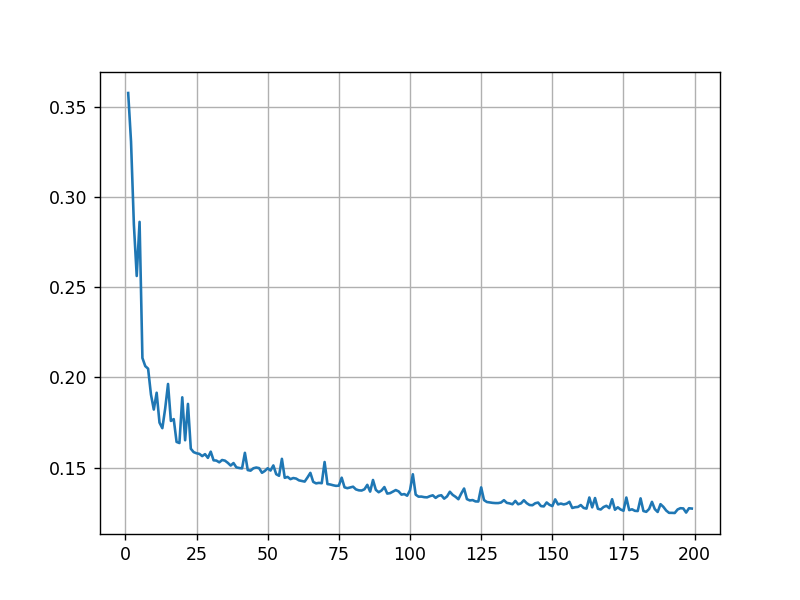

min rmse: 0.124154183800949


In [94]:
plt.ion()
dyp = DynamicUpdate()
dyp.on_launch()

try:
    for res in agent_dbg.neural_net.SGD(
            training_data=train_data,
            epochs=800, mini_batch_size=200, eta=0.4,
            test_data=(X_train.T, y_train)):
        dyp_x.append(epoch_num)
        epoch_num += 1
        dyp_y.append(res)
        if epoch_num % 10 == 0:
            dyp.on_running(dyp_x, dyp_y)
except KeyboardInterrupt:
    print("min rmse: {}".format(min(dyp_y)))

In [88]:
print("- min rmse: {:4f} for {}".format(min(dyp_y), agent_dbg.neural_net.sizes))

- min rmse: 0.077144 for [9, 36, 20, 20, 10, 1]


- min rmse: 0.096779 for [9, 18, 8, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.097438 for [9, 18, 5, 5, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.095456 for [9, 18, 5, 5, 5, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.088339 for [9, 36, 10, 10, 10, 1], epochs=500, mini_batch_size=50, eta=0.5
- min rmse: 0.089725 for [9, 36, 20, 20, 10, 1], epochs=800, mini_batch_size=80, eta=0.7
- min rmse: 0.077144 for [9, 36, 20, 20, 10, 1], epochs=800, mini_batch_size=20, eta=1.4

## Сравним

In [44]:
rfcls = RandomForestWrapper(n_jobs=50)

In [45]:
next(rfcls.SGD(
    training_data=train_data,
    epochs=500,
    mini_batch_size=50,
    eta=0.1))

In [46]:
rfcls.evaluate(X_train.T, y_train)

0.039722006904538754